## Import libraries and USE GPU

In [3]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Prepare Dataset

In [4]:
# Load .mat data, will be loaded as dictionary object so you need to extract values from it.
data = scpy.loadmat("matlab15000.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["unnamed"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='float32')
# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=SEED)
######################################################################################################

(15000, 1000)
(15000, 1)


### Split dataset into train, test and validation.

In [5]:
x_val = x_test[:1500]
y_val = y_test[:1500]
x_test_to_use = x_test[1500:]
y_test_to_use = y_test[1500:]

### Check dimension of train, test and validation dataset.

In [5]:
len(x_train), len(x_val), len(x_test_to_use)

(12000, 1500, 1500)

### Define Convolutional Model as Described in the Paper

Model: "conv_model_paper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 994, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 994, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 994, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 48)           7728      
                                                                 
 batch_normalization_1 (Batc  (None, 120, 48)     

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-06 10:29:23.905097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


 25/375 [=>............................] - ETA: 0s - loss: 2.1468 - accuracy: 0.3850  

2022-10-06 10:29:24.176474: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 10:29:24.199017: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


375/375 [==============================] - 3s 5ms/step - loss: 1.0788 - accuracy: 0.6097 - val_loss: 0.5439 - val_accuracy: 0.7947
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.6366 - accuracy: 0.7437 - val_loss: 0.3895 - val_accuracy: 0.8467
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.5069 - accuracy: 0.7947 - val_loss: 0.3284 - val_accuracy: 0.8780
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.4449 - accuracy: 0.8244 - val_loss: 0.2932 - val_accuracy: 0.9007
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 0.4041 - accuracy: 0.8465 - val_loss: 0.2729 - val_accuracy: 0.9113
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3714 - accuracy: 0.8600 - val_loss: 0.2498 - val_accuracy: 0.9200
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3473 - accuracy: 0.8723 - val_loss: 0.2294 - val_accuracy: 0.9207
Epoch 8/100

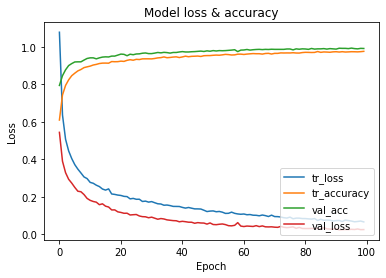

In [6]:
import tensorflow_model_optimization as tfmot

model = tf.keras.Sequential(name='conv_model_paper')
model.add(tf.keras.layers.InputLayer(input_shape=(1000,1)))
model.add(tf.keras.layers.Conv1D(32,7))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=8))
model.add(tf.keras.layers.Conv1D(48,5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save the model without optimization and convert it to tflite format

In [7]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('conv_model_paper.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvyyw7zyf/assets


INFO:tensorflow:Assets written to: /tmp/tmpvyyw7zyf/assets
2022-10-06 10:32:10.334637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:32:10.334659: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:32:10.335113: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvyyw7zyf
2022-10-06 10:32:10.336996: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:32:10.337010: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvyyw7zyf
2022-10-06 10:32:10.341964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-06 10:32:10.343512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:32:10.389097: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

88160

In [8]:
!xxd -i conv_model_paper.tflite > conv_model_paper.cc

## Quantize same model and save it in tflite format.

In [9]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('conv_model_paper_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpd_nnl9mk/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_nnl9mk/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:32:22.149760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:32:22.149776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:32:22.149890: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd_nnl9mk
2022-10-06 10:32:22.151344: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:32:22.151359: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd_nnl9mk
2022-10-06 10:32:22.157772: I tensorflow/cc/saved_model/loade

RuntimeError: tensorflow/lite/kernels/conv.cc:350 input->dims->size != 4 (3 != 4)Node number 1 (CONV_2D) failed to prepare.

#### Final version of Model in Paper by Yuxuan

Model: "final_conv_model_paper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 16)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 125, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 16)           1296      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 16)           0         
 1D)                                                             
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 16) 

2022-10-12 11:41:50.399637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


 39/375 [==>...........................] - ETA: 0s - loss: 1.3960 - accuracy: 0.3446  

2022-10-12 11:41:50.668523: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-12 11:41:50.689410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


375/375 [==============================] - 2s 3ms/step - loss: 1.0968 - accuracy: 0.4338 - val_loss: 0.9607 - val_accuracy: 0.5433
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 0.8678 - accuracy: 0.6396 - val_loss: 0.7800 - val_accuracy: 0.6813
Epoch 3/100
375/375 [==============================] - 2s 4ms/step - loss: 0.7039 - accuracy: 0.7188 - val_loss: 0.6440 - val_accuracy: 0.7313
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 0.5971 - accuracy: 0.7617 - val_loss: 0.5610 - val_accuracy: 0.7733
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.5274 - accuracy: 0.8083 - val_loss: 0.5036 - val_accuracy: 0.8113
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4799 - accuracy: 0.8334 - val_loss: 0.4631 - val_accuracy: 0.8373
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 0.4467 - accuracy: 0.8425 - val_loss: 0.4372 - val_accuracy: 0.8373
Epoch 8/100

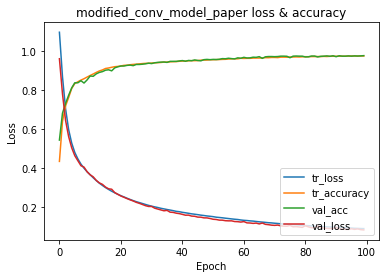

In [6]:
final_conv_model_paper = tf.keras.Sequential(name='final_conv_model_paper')
final_conv_model_paper.add(tf.keras.layers.Reshape((1000,1),name='Reshape', input_shape=(1000,)))
final_conv_model_paper.add(tf.keras.layers.Conv1D(16,7,padding='same',activation='relu'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(8,padding='same'))
final_conv_model_paper.add(tf.keras.layers.Conv1D(16,5,padding='same',activation='relu'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(4,padding='same'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(4,padding='same'))
final_conv_model_paper.add(tf.keras.layers.Flatten())
final_conv_model_paper.add(tf.keras.layers.Dense(3, activation='softmax'))


print(final_conv_model_paper.summary())
final_conv_model_paper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = final_conv_model_paper.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('modified_conv_model_paper loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating modified_conv_model_paper
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

#### Convert final model to TF-Lite without any optimizations.

In [8]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(final_conv_model_paper)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('final_conv_model_paper.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqfbdgrzs/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfbdgrzs/assets
2022-10-12 11:47:20.160207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-12 11:47:20.160222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-12 11:47:20.160298: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.161104: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-12 11:47:20.161114: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.164404: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-12 11:47:20.186333: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.192173: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

14440

### Convert final model to TF-Lite with quantization.

In [7]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(final_conv_model_paper)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('final_conv_model_paper_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpfoo48sqn/assets


INFO:tensorflow:Assets written to: /tmp/tmpfoo48sqn/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-12 11:45:53.371003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-12 11:45:53.371018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-12 11:45:53.371350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfoo48sqn
2022-10-12 11:45:53.372206: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-12 11:45:53.372221: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfoo48sqn
2022-10-12 11:45:53.375203: I tensorflow/compiler/mlir/mlir_g

11032

## Change the model described in the paper to make it suitable for conversion to TFLite, and quantization.

Model: "conv_modified_conv_model_paper_paper_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 1000, 1, 32)       1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 1, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 1, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 1, 48)        0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPoolin

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 2s 4ms/step - loss: 0.7672 - accuracy: 0.6788 - val_loss: 0.5392 - val_accuracy: 0.7833
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4398 - accuracy: 0.8395 - val_loss: 0.3800 - val_accuracy: 0.8507
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3291 - accuracy: 0.8963 - val_loss: 0.3248 - val_accuracy: 0.8860
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2688 - accuracy: 0.9199 - val_loss: 0.2578 - val_accuracy: 0.9067
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2283 - accuracy: 0.9305 - val_loss: 0.2120 - val_accuracy: 0.9327
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.1984 - accuracy: 0.9402 - val_loss: 0.1811 - val_accuracy: 0.9393
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1759 - accuracy: 0.9448 - val_loss: 0.1637 - val_accuracy: 0.9440
Epoch 8/100

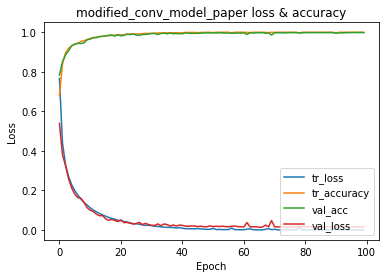

In [10]:
from genericpath import samefile
import tensorflow_model_optimization as tfmot

modified_conv_model_paper = tf.keras.Sequential(name='conv_modified_conv_model_paper_paper_2D')
modified_conv_model_paper.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape', input_shape=(1000,)))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(32,7,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(8,8,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(48,5,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Flatten())
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(3, activation='softmax'))


print(modified_conv_model_paper.summary())
modified_conv_model_paper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modified_conv_model_paper.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('modified_conv_model_paper loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating modified_conv_model_paper
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save model as .tflite and .pb

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(modified_conv_model_paper)
modidified_conv_model_converted = converter.convert()
tflite_model_file = pathlib.Path('conv_model_paper_2D.tflite')
tflite_model_file.write_bytes(modidified_conv_model_converted)

INFO:tensorflow:Assets written to: /tmp/tmp4dvj30xg/assets


INFO:tensorflow:Assets written to: /tmp/tmp4dvj30xg/assets
2022-10-06 10:35:25.175786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:35:25.175803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:35:25.175888: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.176835: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:35:25.176846: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.180699: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:35:25.209889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.216447: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

219920

In [12]:
!xxd -i conv_model_paper_2D.tflite > conv_model_paper_2D.cc

## Quantize same model and save it.

In [13]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(modified_conv_model_paper)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('conv_model_paper_2D_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpvsg4qhk4/assets


INFO:tensorflow:Assets written to: /tmp/tmpvsg4qhk4/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:35:30.343080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:35:30.343097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:35:30.343211: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvsg4qhk4
2022-10-06 10:35:30.344158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:35:30.344170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvsg4qhk4
2022-10-06 10:35:30.347950: I tensorflow/cc/saved_model/loade

62736

In [14]:
!xxd -i conv_model_paper_2D_optimized.tflite > conv_model_paper_2D_optimized.cc

## Define experimental random 2D convolutional model.

Model: "custom_2D_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1000, 1, 8)        208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 500, 1, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4000)              0         
                                                                 
 output (Dense)              (None, 3)                 12003     
                                                                 
Total params: 12,211
Trainable params: 12,211
Non-trainable params: 0
__________________________________________

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 1s 3ms/step - loss: 0.7049 - accuracy: 0.7482 - val_loss: 0.4442 - val_accuracy: 0.8667
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3371 - accuracy: 0.9085 - val_loss: 0.2578 - val_accuracy: 0.9247
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2221 - accuracy: 0.9372 - val_loss: 0.1939 - val_accuracy: 0.9453
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1728 - accuracy: 0.9488 - val_loss: 0.1598 - val_accuracy: 0.9487
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9561 - val_loss: 0.1403 - val_accuracy: 0.9527
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1235 - accuracy: 0.9635 - val_loss: 0.1253 - val_accuracy: 0.9613
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1079 - accuracy: 0.9682 - val_loss: 0.1172 - val_accuracy: 0.9653
Epoch 8/100

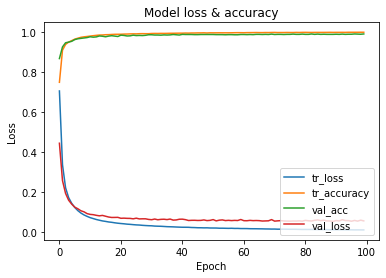

In [15]:
my_custom_model = tf.keras.Sequential(name='custom_2D_conv_model')
my_custom_model.add(tf.keras.Input(shape=(x_train.shape[1],)))
my_custom_model.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape'))
my_custom_model.add(tf.keras.layers.Conv2D(8,5,padding='same',activation='relu'))
my_custom_model.add(tf.keras.layers.MaxPooling2D(2,2, padding='same'))
my_custom_model.add(tf.keras.layers.Flatten())
my_custom_model.add(tf.keras.layers.Dense(3,activation='softmax', name="output"))


print(my_custom_model.summary())
my_custom_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = my_custom_model.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save custom model as .tflite

In [16]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('my_custom_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8sg93y9j/assets


INFO:tensorflow:Assets written to: /tmp/tmp8sg93y9j/assets
2022-10-06 10:38:28.737573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:38:28.737590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:38:28.737673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.738317: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:38:28.738328: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.740182: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:38:28.755834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.760176: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

52432

In [17]:
!xxd -i my_custom_model.tflite > my_custom_model.cc

## Quantize custom model and save it.

In [18]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('my_custom_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpmhz6e2sm/assets


INFO:tensorflow:Assets written to: /tmp/tmpmhz6e2sm/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:38:43.470713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:38:43.470733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:38:43.470829: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmhz6e2sm
2022-10-06 10:38:43.471406: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:38:43.471419: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmhz6e2sm
2022-10-06 10:38:43.473459: I tensorflow/cc/saved_model/loade

16712

In [19]:
!xxd -i my_custom_model_optimized.tflite > my_custom_model_optimized.cc

### Quantize model to INT8 and save it.

In [14]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_file = pathlib.Path('my_custom_model_int8_quant.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmplrt78c1u/assets


INFO:tensorflow:Assets written to: /tmp/tmplrt78c1u/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 09:31:25.857597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 09:31:25.857611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 09:31:25.857717: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplrt78c1u
2022-10-06 09:31:25.858310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 09:31:25.858321: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplrt78c1u
2022-10-06 09:31:25.859923: I tensorflow/cc/saved_model/loade

16704

In [17]:
!xxd -i my_custom_model_int8_quant.tflite > my_custom_model_int8_quant.cc

## Define Dense model.

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 1000)              0         
                                                                 
 dense_82 (Dense)            (None, 4)                 4004      
                                                                 
 dense_83 (Dense)            (None, 3)                 15        
                                                                 
Total params: 4,019
Trainable params: 4,019
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


C:\Users\101\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


188/188 [==============================] - 1s 4ms/step - loss: 1.1398 - accuracy: 0.4277 - val_loss: 0.9400 - val_accuracy: 0.5287
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.9051 - accuracy: 0.5549 - val_loss: 0.8220 - val_accuracy: 0.6140
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 0.8082 - accuracy: 0.6423 - val_loss: 0.7575 - val_accuracy: 0.6687
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 0.7500 - accuracy: 0.6888 - val_loss: 0.7138 - val_accuracy: 0.6973
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.7069 - accuracy: 0.7175 - val_loss: 0.6797 - val_accuracy: 0.7213
Epoch 6/100
188/188 [==============================] - 1s 3ms/step - loss: 0.6717 - accuracy: 0.7377 - val_loss: 0.6510 - val_accuracy: 0.7407
Epoch 7/100
188/188 [==============================] - 1s 3ms/step - loss: 0.6414 - accuracy: 0.7565 - val_loss: 0.6253 - val_accuracy: 0.7573
Epoch 8/100

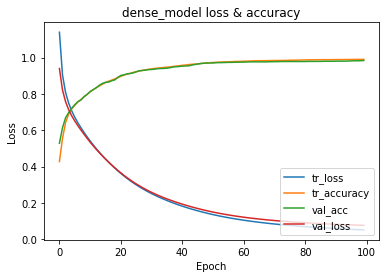

In [46]:
SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
# train_dataset.unbatch()

dense_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1000,)),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(3,activation='softmax')
])


dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
dense_model.summary()              

history=dense_model.fit(train_dataset,validation_data=val_dataset, epochs=100)
# dense_model.evaluate(val_dataset)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('dense_model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating dense_model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

## Save dense model as tflite - no optimization.

In [19]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(dense_model)
float_tflite_model = float_converter.convert()
import pathlib
tflite_model_file = pathlib.Path('dense_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp38stdgnu/assets


INFO:tensorflow:Assets written to: /tmp/tmp38stdgnu/assets
2022-10-06 09:38:19.857854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 09:38:19.857870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 09:38:19.857945: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp38stdgnu
2022-10-06 09:38:19.858480: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 09:38:19.858492: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp38stdgnu
2022-10-06 09:38:19.860266: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 09:38:19.874742: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp38stdgnu
2022-10-06 09:38:19.878366: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

18340

In [20]:
!xxd -i dense_model.tflite > dense_model.cc

## Quantize dense model and save it as tflite.

In [19]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(dense_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('dense_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpsm4jy34r/assets


INFO:tensorflow:Assets written to: /tmp/tmpsm4jy34r/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-10 09:14:36.599325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-10 09:14:36.599343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-10 09:14:36.599439: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsm4jy34r
2022-10-10 09:14:36.599948: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-10 09:14:36.599960: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsm4jy34r
2022-10-10 09:14:36.601866: I tensorflow/cc/saved_model/loade

7048

In [22]:
!xxd -i dense_model_optimized.tflite > dense_model_optimized.cc

In [49]:
interpreter = tf.lite.Interpreter(model_path='dense_model.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [23]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, indices):
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test_to_use[index]
    test_data=np.expand_dims(test_data, axis=0)
    test_labels = y_train[index]

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output[0])
    print(output[1])
    print(output[2])
    predictions = output.argmax()

  return predictions

In [24]:
import matplotlib.pylab as plt
tflite_model_file = 'dense_model.tflite'
# Change this to test a different image
indice = 333

## Helper function to test the models on one image
def test_model(tflite_file, indice, model_type):

  predictions = run_tflite_model(tflite_file, [indice])

  print(f" Model \n True:{y_test_to_use[indice]}, Predicted:{predictions}")
  
test_model(tflite_model_file, indice, model_type="Float")

8.737704e-08
0.00016263525
0.99983716
 Model 
 True:[2], Predicted:2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
x_test[123]

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path='float_model.tflite')

In [25]:
import numpy as np

def run_tflite_model_for_eval(interpreter, indices):
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test_to_use[index]
    test_data=np.expand_dims(test_data, axis=0)

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions = output.argmax()
  return predictions
  
def evaluate_model(interpreter):
  output_predictions =[]
  for i in range(len(x_test_to_use)):
    output_predictions.append(run_tflite_model_for_eval(interpreter,[i]))
  output_predictions = np.array(output_predictions)
  output_predictions = np.expand_dims(output_predictions, axis=1)
  accuracy = (output_predictions == y_test_to_use).mean()
  return accuracy

In [21]:
interpreter = tf.lite.Interpreter(model_path='dense_model_optimized.tflite')
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Optimized dense_model TFLite test_accuracy:', test_accuracy)
# print('Quant TF test accuracy:', q_aware_model_accuracy)

Optimized dense_model TFLite test_accuracy: 0.9826666666666667


### Model with annotated layers for quantization -- Trial can be skipped.

In [ ]:
# ### Quantization based training
# import tensorflow_model_optimization as tfmot
# quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer

# model = tf.keras.Sequential([
# #### tf.keras.layers :

# quantize_annotate_layer((tf.keras.layers.Reshape((1000,1,1),name='Reshape', input_shape=(1000,)))),
# quantize_annotate_layer(tf.keras.layers.Conv2D(16,7,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Activation('relu')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(4,4,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Conv2D(8,5, padding='same')),
# quantize_annotate_layer(tf.keras.layers.Activation('relu')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(4,4,padding='same')),
# quantize_annotate_layer(tf.keras.layers.MaxPooling2D(2,2,padding='same')),
# quantize_annotate_layer(tf.keras.layers.Flatten()),
# quantize_annotate_layer(tf.keras.layers.Dense(32)),
# quantize_annotate_layer(tf.keras.layers.Dense(3, activation='softmax')),
# ])
# quantized_model = tfmot.quantization.keras.quantize_apply(model)
# # quant_aware_model = tfmot.quantization.keras.quantize_model(base_model)
# # quant_aware_model.summary()
# print(model.summary())
# quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = quantized_model.fit(x_train, y_train ,epochs=50, validation_data=(x_test, y_test), verbose=1)   


# # Plotting accuracy and loss
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_loss'])


# plt.title('Model loss & accuracy')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# # accuracy!
# print("Training results")
# print(f"Accuracy: {history.history['accuracy'][-1]}")
# print(f"Loss: {history.history['loss'][-1]}")

# # evaluating model
# print("Evaluation results")
# print(f"Accuracy: {history.history['val_accuracy'][-1]}")
# print(f"Loss: {history.history['val_loss'][-1]}")


# plt.show()